#**Batyrali Bazar - Final Project on topic 8 - Water consumption worldwide**
##**Comparison of average per capita water usage across different countries.**

###**Packages:**

In [2]:
import pandas as pd
import numpy as np

#For Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#For statistical tests
from scipy import stats

#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


###**1. Data Preparation and Cleaning**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data Vis Final Proj/Global Water Usage Statistics.csv')

#Changed some of the data from str to float

columns_tofloat = data[['Yearly  Water Used (m³, thouand of liters)','Daily Water Used Per Capita (liters)']]
for c in columns_tofloat:
  data[c] = data[c].str.replace(',','',regex=False).astype('float')

data['Population'] = data['Population'].str.replace(',','',regex=False).astype('int')
data['Country'] = data['Country'].replace('Russia','Russian Federation')


# Changed yearly water from thousands to billions of liters
data['Yearly  Water Used (m³, thouand of liters)'] = data['Yearly  Water Used (m³, thouand of liters)'] / 1_000_000
data.rename(columns={'Yearly  Water Used (m³, thouand of liters)':'Yearly Water Used (billions of liters)'},inplace=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 179 non-null    object 
 1   Yearly Water Used (billions of liters)  179 non-null    float64
 2   Daily Water Used Per Capita (liters)    179 non-null    float64
 3   Population                              179 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 5.7+ KB
None


In [4]:
# Also added more data
gdp_per_capita_data = pd.read_csv('/content/drive/MyDrive/Data Vis Final Proj/gdp_per_capita.csv',header=2,usecols=['Country Name','2022'])
gdp_per_capita_data.rename(columns={'Country Name':'Country','2022':'GDP per Capita($)'}, inplace=True)
data = pd.merge(data,gdp_per_capita_data,how='inner',on='Country')

gdp_current_data = pd.read_csv('/content/drive/MyDrive/Data Vis Final Proj/gdp_total_current.csv',header=2,usecols=['Country Name','2022'])
gdp_current_data.rename(columns={'Country Name':'Country','2022':'GDP Current($)'}, inplace=True)
data = pd.merge(data,gdp_current_data,how='inner',on='Country')

urban_data = pd.read_csv('/content/drive/MyDrive/Data Vis Final Proj/Urban population %.csv',header=2,usecols=['Country Name','2022'])
urban_data.rename(columns={'Country Name':'Country','2022':'Urban Population(%)'}, inplace=True)
data = pd.merge(data,urban_data,how='inner',on='Country')

industry_water_data = pd.read_csv('/content/drive/MyDrive/Data Vis Final Proj/water_withdrawals_industry.csv',header=2,usecols=['Country Name','2021'])
industry_water_data.rename(columns={'Country Name':'Country','2021':'Industry Water Withdrawals(%)'}, inplace=True)
data = pd.merge(data,industry_water_data,how='inner',on='Country')

data = data.dropna()

In [5]:
# Have created new columns
data['Water Usage Efficiency($/Liter/Day)'] = data['GDP per Capita($)']/data['Daily Water Used Per Capita (liters)']
data['Industrial Economic Intensity($)'] =  data['Industry Water Withdrawals(%)']*data['GDP per Capita($)']

In [6]:
#Data that I will later use for ANOVA: 3 groups by urbanization level
low_urban = data[data['Urban Population(%)'] < 33]['Water Usage Efficiency($/Liter/Day)']
moderate_urban = data[(data['Urban Population(%)']>33)&(data['Urban Population(%)']<66)]['Water Usage Efficiency($/Liter/Day)']
high_urban = data[data['Urban Population(%)']>66]['Water Usage Efficiency($/Liter/Day)']


#That's basicly it for data preparation.

###**2. Descriptive Statistics**

In [7]:
 # Have to mention that I've rounded only for better visualisation (not for further calculations)

# mean
data_mean = data.select_dtypes('number').mean()
print("Mean:")
print(data_mean.round(2))
print()

# median
data_median  = data.select_dtypes('number').median()
print("Median:")
print(data_median.round(2))
print()

# std
data_std = data.select_dtypes('number').std()
print("Standard Deviation:")
print(data_std.round(2))
print()

# range
data_range = data.select_dtypes('number').max() - data.select_dtypes('number').min()
print("Range:")
print(data_range.round(2))
print()

Mean:
Yearly Water Used (billions of liters)    2.339552e+04
Daily Water Used Per Capita (liters)      1.363140e+03
Population                                4.174615e+07
GDP per Capita($)                         1.854555e+04
GDP Current($)                            6.204130e+11
Urban Population(%)                       6.101000e+01
Industry Water Withdrawals(%)             1.836000e+01
Water Usage Efficiency($/Liter/Day)       2.869000e+01
Industrial Economic Intensity($)          5.116727e+05
dtype: float64

Median:
Yearly Water Used (billions of liters)    2.118000e+03
Daily Water Used Per Capita (liters)      8.500000e+02
Population                                8.109989e+06
GDP per Capita($)                         6.846430e+03
GDP Current($)                            5.166688e+10
Urban Population(%)                       6.282000e+01
Industry Water Withdrawals(%)             7.510000e+00
Water Usage Efficiency($/Liter/Day)       9.130000e+00
Industrial Economic Intensity($)   

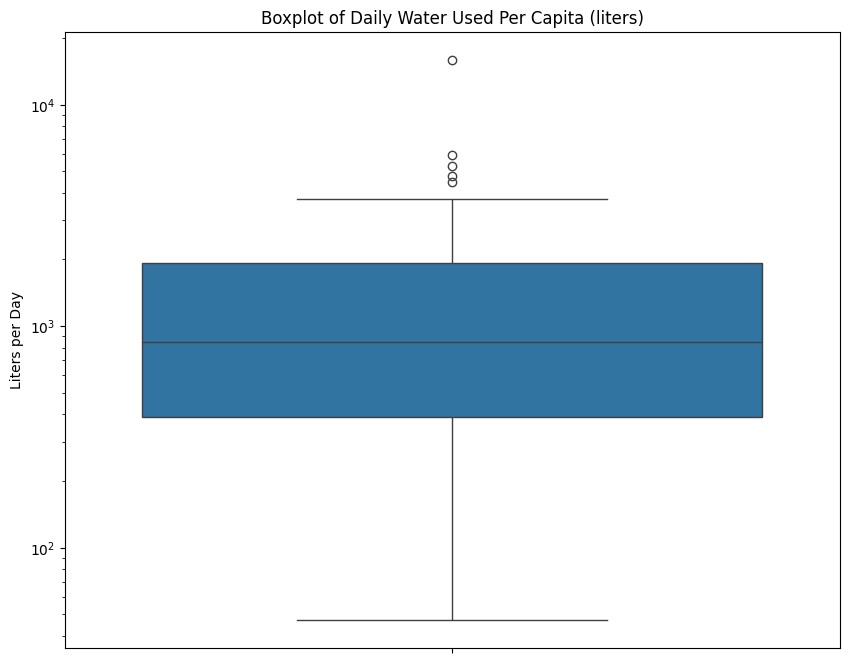

In [56]:
# I have decided to add only 1 boxplot, to do not ovewhelm
plt.figure(figsize=(10,8))
sns.boxplot(y=data['Daily Water Used Per Capita (liters)'])
plt.title('Boxplot of Daily Water Used Per Capita (liters)')
plt.ylabel('Liters per Day')
plt.yscale('log') # Had do use log scale because of wide range of data
plt.show()

###**3. Correlation Analysis**

<Axes: >

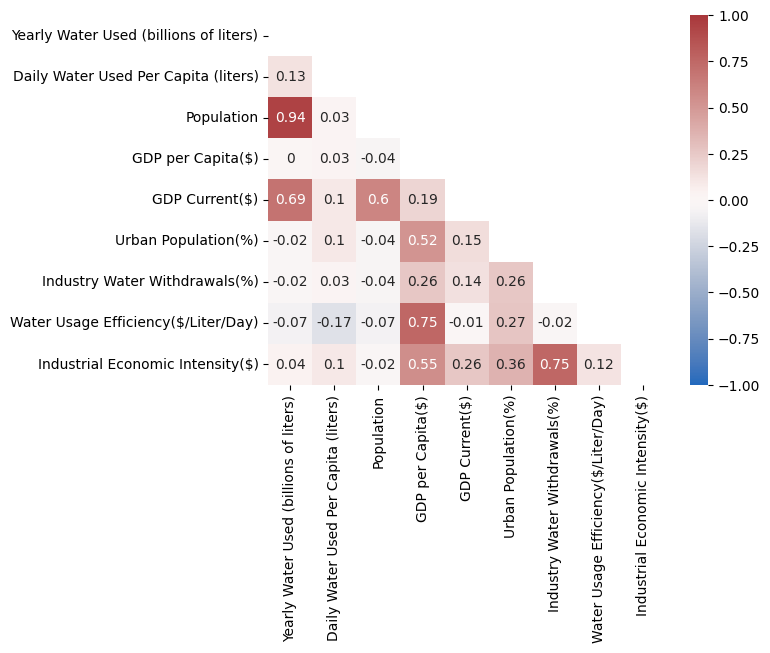

In [9]:
# Correlation Matrix (heatmap in step 6. Data Visualization)
corr_matrix = data.select_dtypes('number').corr(method='pearson').round(2)

# Heatmap
corr_mask = np.triu(np.ones_like(corr_matrix,dtype=bool)) # Mask to hide mirrored values
sns.heatmap(corr_matrix, annot=True,vmin=-1,vmax=1,mask=corr_mask, cmap='vlag')

#plt.savefig('correlation_heatmap.svg', format='svg', bbox_inches='tight')

###**4. Linear Regression**

R-squared: 0.8824055646099954


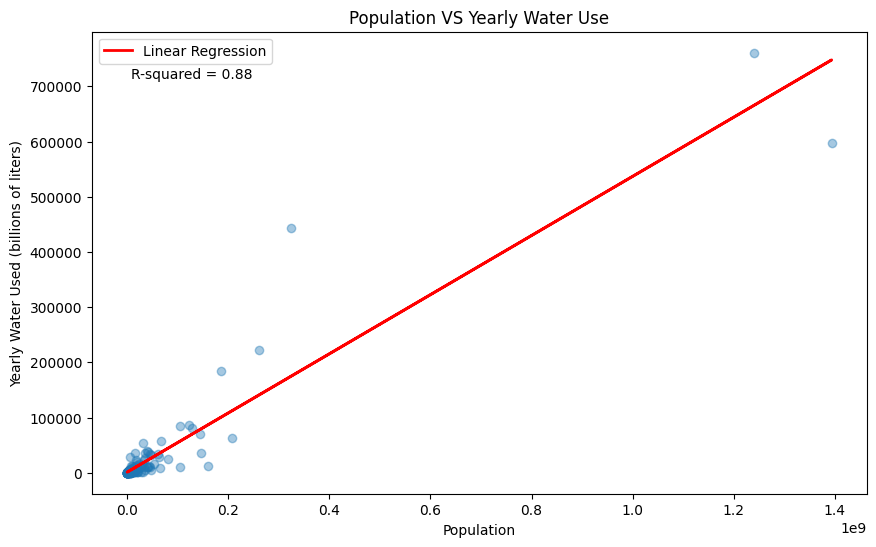

Intercept: [1020.96069246]
Coefficient: [0.00053597]


In [10]:
# All 3 scatter plots in step 6. Data Visualization
# Linear Regression 1
linear_regression_model1 = LinearRegression()
X_1 = data[['Population']]
y_1 = data[['Yearly Water Used (billions of liters)']]
linear_regression_model1.fit(X_1,y_1)

y_pred_1 = linear_regression_model1.predict(X_1)
r2_1 = r2_score(y_1,y_pred_1)
print(f"R-squared: {r2_1}")

# Linear Regression 1 scatter plot
plt.figure(figsize=(10,6))
plt.scatter(X_1,y_1,alpha=0.4)
plt.plot(X_1, y_pred_1, color='red',linewidth='2',label='Linear Regression')
plt.xlabel('Population')
plt.ylabel('Yearly Water Used (billions of liters)')
plt.title('Population VS Yearly Water Use')
plt.legend()
plt.text(0.05,0.9,f'R-squared = {r2_1:.2f}',transform=plt.gca().transAxes)
plt.show()

print(f"Intercept: {linear_regression_model1.intercept_}")
print(f"Coefficient: {linear_regression_model1.coef_[0]}")
# R^2 = 0.88, according to Ecology/Environmental Science, if r^2>0.70, then connection is very strong

R-squared: 0.5552933449460233


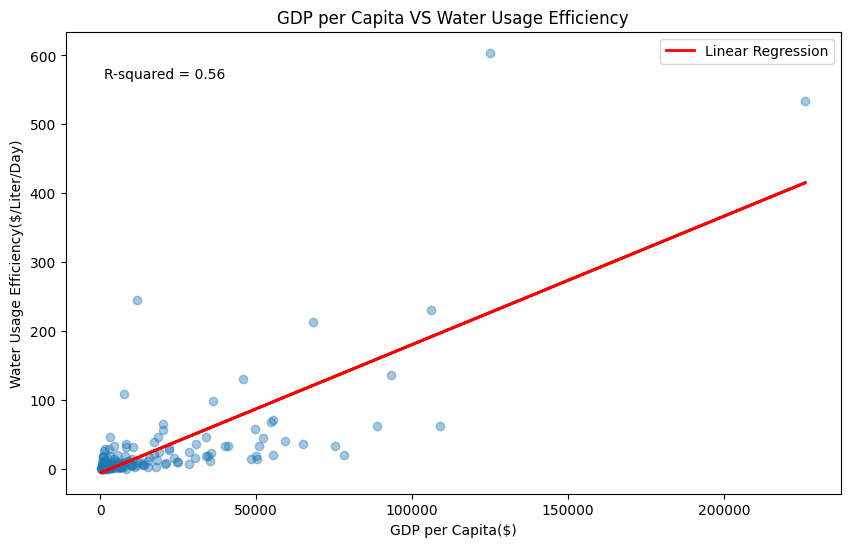

Intercept: [-5.87308194]
Coefficient: [0.00186376]


In [11]:
# Linear Regression 2
linear_regression_model2 = LinearRegression()
X_2 = data[['GDP per Capita($)']]
y_2 = data[['Water Usage Efficiency($/Liter/Day)']]
linear_regression_model2.fit(X_2,y_2)

y_pred_2 = linear_regression_model2.predict(X_2)
r2_2 = r2_score(y_2,y_pred_2)
print(f"R-squared: {r2_2}")

# Linear Regression 2 scatter plot
plt.figure(figsize=(10,6))
plt.scatter(X_2,y_2,alpha=0.4)
plt.plot(X_2, y_pred_2, color='red',linewidth='2',label='Linear Regression')
plt.xlabel('GDP per Capita($)')
plt.ylabel('Water Usage Efficiency($/Liter/Day)')
plt.title('GDP per Capita VS Water Usage Efficiency')
plt.legend()
plt.text(0.05,0.9,f'R-squared = {r2_2:.2f}',transform=plt.gca().transAxes)
plt.show()


print(f"Intercept: {linear_regression_model2.intercept_}")
print(f"Coefficient: {linear_regression_model2.coef_[0]}")

# R^2 = 0.56, according to Ecology/Environmental Science, if r^2>0.50, then connection is strong

R-squared: 0.0011913342840460528


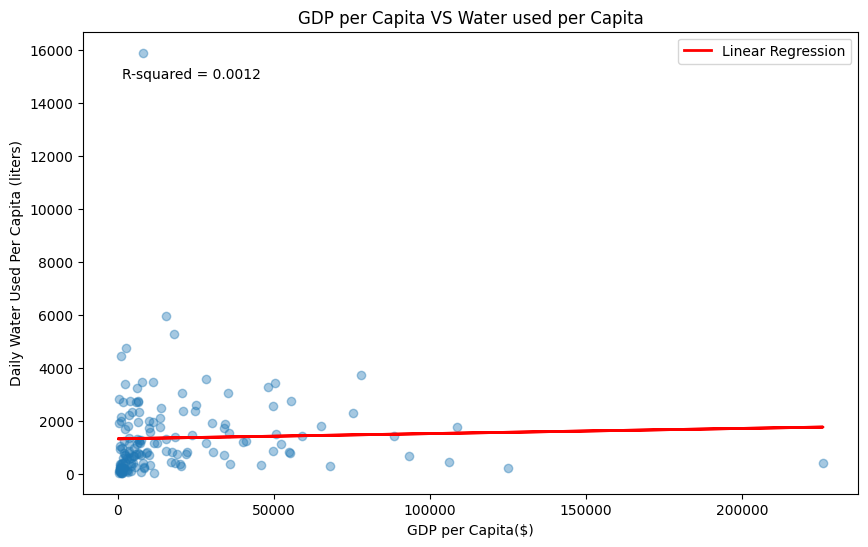

Intercept: [1326.89459221]
Coefficient: [0.0019546]


In [12]:
# Linear Regression 3
linear_regression_model3 = LinearRegression()
X_3 = data[['GDP per Capita($)']]
y_3 = data[['Daily Water Used Per Capita (liters)']]
linear_regression_model3.fit(X_3,y_3)

y_pred_3 = linear_regression_model3.predict(X_3)
r2_3 = r2_score(y_3,y_pred_3)
print(f"R-squared: {r2_3}")

# Linear Regression 3 scatter plot
plt.figure(figsize=(10,6))
plt.scatter(X_3,y_3,alpha=0.4)
plt.plot(X_3, y_pred_3, color='red',linewidth='2',label='Linear Regression')
plt.xlabel('GDP per Capita($)')
plt.ylabel('Daily Water Used Per Capita (liters)')
plt.title('GDP per Capita VS Water used per Capita')
plt.legend()
plt.text(0.05,0.9,f'R-squared = {r2_3:.4f}',transform=plt.gca().transAxes)
plt.show()

print(f"Intercept: {linear_regression_model3.intercept_}")
print(f"Coefficient: {linear_regression_model3.coef_[0]}")

# R^2 = 0.0012, no connection

In [13]:
data

,Country,Yearly Water Used (billions of liters),Daily Water Used Per Capita (liters),Population,GDP per Capita($),GDP Current($),Urban Population(%),Industry Water Withdrawals(%),Water Usage Efficiency($/Liter/Day),Industrial Economic Intensity($)
0,Afghanistan,20280.0,2843.0,19542982,357.261153,1.449724e+10,26.616,0.831988,0.125663,2.972368e+02
1,Albania,1311.0,1196.0,3003387,6846.426143,1.901724e+10,63.799,1.256281,5.724437,8.601038e+03
2,Algeria,9978.0,678.0,40339329,4961.552577,2.256385e+11,74.772,1.825655,7.317924,9.058082e+03
3,Angola,705.8,99.0,19450959,2929.694455,1.043997e+11,68.081,33.947294,29.592873,9.945520e+04
4,Antigua and Barbuda,11.5,359.0,87674,20117.765331,1.867733e+09,24.346,21.739130,56.038344,4.373427e+05
...,...,...,...,...,...,...,...,...,...,...
152,United States,444300.0,3750.0,324607776,78035.175360,2.600689e+13,83.084,47.198902,20.809380,3.683175e+06
153,Uruguay,3660.0,3046.0,3292224,20691.973899,7.016468e+10,95.688,2.185792,6.793163,4.522836e+04
154,Uzbekistan,54560.0,4752.0,31453574,2578.666894,9.009593e+10,50.466,4.140901,0.542649,1.067800e+04
155,Zambia,1572.0,410.0,10508294,1447.123101,2.916378e+10,45.761,8.269720,3.529569,1.196730e+04


###**5. Statistical Tests**

In [14]:
# I don't strictly need to do KS test according to Central Limit Theorem (CLT), so I didn't

# But what I need, is to check if variances are equal even in a big enough dataset
# For that, I used Levene's test. Also checked only columns for ANOVA test, because in Welch's T-Test we dont need variances at all

#Null Hypothesis: there is no statistically significant difference in variances among the groups
#Alternative Hypothesis: there is statistically significant difference in variances among the groups

levene_stat, p_value_levene = stats.levene(low_urban,moderate_urban,high_urban,center="median")
print(f"Levene's Test Statistic: {levene_stat:.4f}")
print(f"Levene's Test P-value: {p_value_levene:.4f}")

# p_value_levene = 0.1 > 0.05, failed to reject null hypothersis, there is no statistically significant difference in variances among the groups

Levene's Test Statistic: 2.3017
Levene's Test P-value: 0.1036


In [15]:
#Let's compare per capita water usage on Welch's T-Test (didn't use Student's T-test, because in real world data it is safer to assume that variances are unequal)

#Null Hypothesis: there is no difference in daily water usage in different groups by gdp
#Alternative Hypothesis: there is significant difference in daily water usage in different groups by gdp

#For that I need to divide GDP into 2 groups by gdp per capita
gdp_less_mean = data[data['GDP per Capita($)'] < data['GDP per Capita($)'].mean()]['Daily Water Used Per Capita (liters)']
gdp_higher_mean = data[data['GDP per Capita($)'] > data['GDP per Capita($)'].mean()]['Daily Water Used Per Capita (liters)']

#Now we can compare gdp_less_mean and gdp_higher_mean
welch_t,p_value_welch = stats.ttest_ind(gdp_less_mean,gdp_higher_mean, equal_var=False)

print(f"Welch's T-value: {welch_t:.2f}")
print(f"P-value: {p_value_welch:.2f}")
# P-value: 0.29, fail to reject null hypothesis, no statistically significant difference in per capita water consumption between the two groups with diferent gpd per capita

Welch's T-value: -1.06
P-value: 0.29


In [16]:
# Now, I decided to check urabnization level impact on water usage efficiency using Anova test

#Null Hypothesis: there is no difference in water usage efficiency between different levels of urbanization
#Alternative Hypothesis: there is significant difference in water usage efficiency between diferent levels of urbanization

anova_f,p_value_anova = stats.f_oneway(low_urban,moderate_urban,high_urban)

print(f"Anova f-value: {anova_f:.2f}")
print(f"P-value: {p_value_anova:.2f}")
 # P-value: 0.03, we reject null hypothesis, so there is statistically significant difference

Anova f-value: 3.44
P-value: 0.03


###**6. Data Visualization**

In [17]:
# Water consumption illustration on world map
world_map1 = px.choropleth(
    data,
    locations="Country",
    color="Yearly Water Used (billions of liters)",
    color_continuous_scale="Viridis",
    title="Total Water Consumption Worldwide",
    projection="natural earth",
    locationmode="country names"
)

world_map1.show()


In [18]:
# Daily water use per capita on world map, for contrast
world_map2 = px.choropleth(
    data,
    locations="Country",
    color="Daily Water Used Per Capita (liters)",
    color_continuous_scale="Viridis",
    title="Water Consumption Per Capita Worldwide",
    projection="natural earth",
    locationmode="country names"
)

world_map2.show()

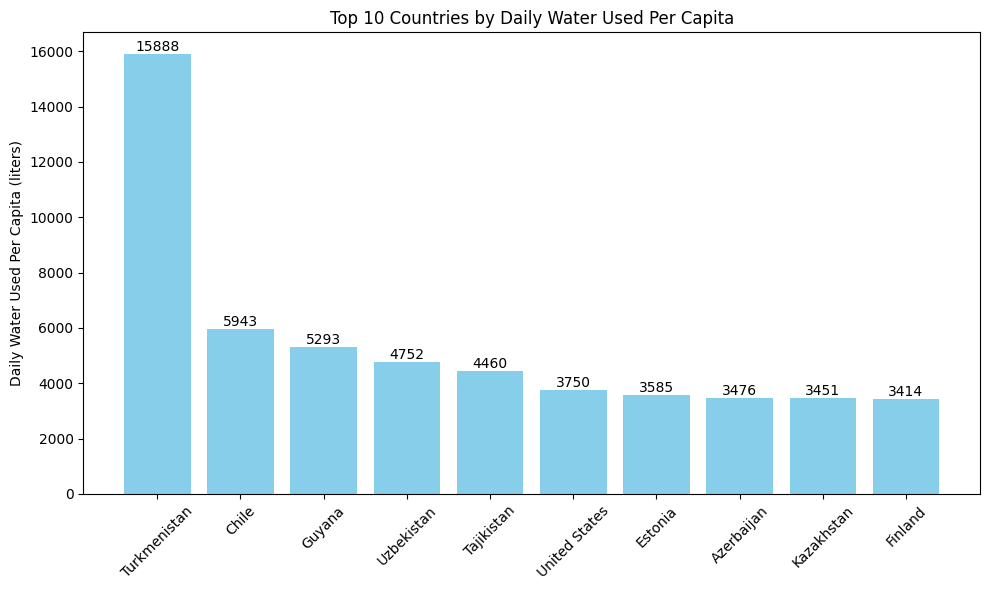

In [19]:
# Top 10 countries by water consumption per capita

data_top5 = data.sort_values('Daily Water Used Per Capita (liters)', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(data_top5['Country'], data_top5['Daily Water Used Per Capita (liters)'], color='skyblue')

ax.bar_label(bars)

ax.set_ylabel('Daily Water Used Per Capita (liters)')
ax.set_title('Top 10 Countries by Daily Water Used Per Capita')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

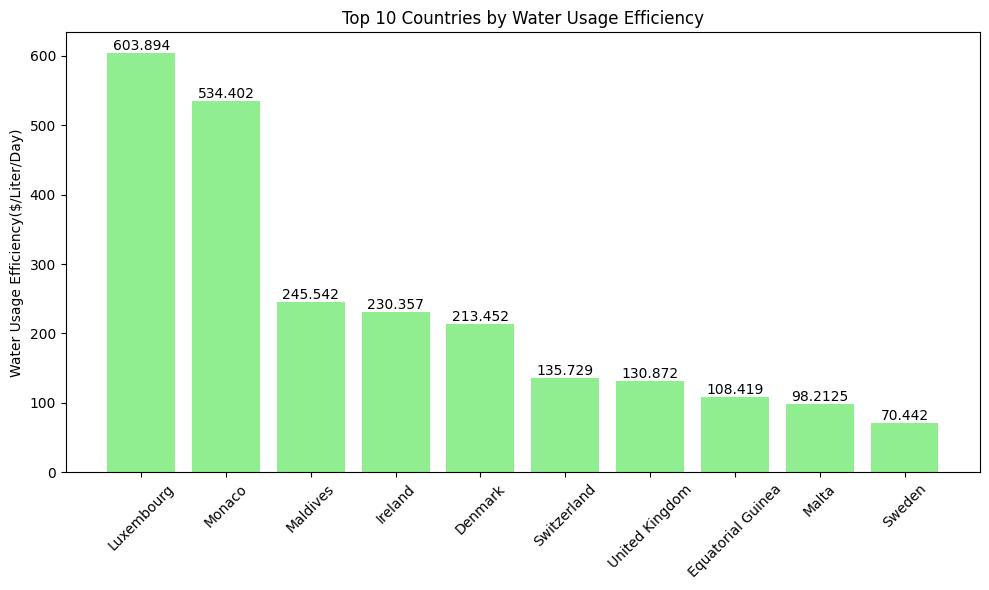

In [20]:
# And now, let's see Top 10 countries by water usage efficiency

data_top5 = data.sort_values('Water Usage Efficiency($/Liter/Day)', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(data_top5['Country'], data_top5['Water Usage Efficiency($/Liter/Day)'], color='lightgreen')

ax.bar_label(bars)

ax.set_ylabel('Water Usage Efficiency($/Liter/Day)')
ax.set_title('Top 10 Countries by Water Usage Efficiency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
data

,Country,Yearly Water Used (billions of liters),Daily Water Used Per Capita (liters),Population,GDP per Capita($),GDP Current($),Urban Population(%),Industry Water Withdrawals(%),Water Usage Efficiency($/Liter/Day),Industrial Economic Intensity($)
0,Afghanistan,20280.0,2843.0,19542982,357.261153,1.449724e+10,26.616,0.831988,0.125663,2.972368e+02
1,Albania,1311.0,1196.0,3003387,6846.426143,1.901724e+10,63.799,1.256281,5.724437,8.601038e+03
2,Algeria,9978.0,678.0,40339329,4961.552577,2.256385e+11,74.772,1.825655,7.317924,9.058082e+03
3,Angola,705.8,99.0,19450959,2929.694455,1.043997e+11,68.081,33.947294,29.592873,9.945520e+04
4,Antigua and Barbuda,11.5,359.0,87674,20117.765331,1.867733e+09,24.346,21.739130,56.038344,4.373427e+05
...,...,...,...,...,...,...,...,...,...,...
152,United States,444300.0,3750.0,324607776,78035.175360,2.600689e+13,83.084,47.198902,20.809380,3.683175e+06
153,Uruguay,3660.0,3046.0,3292224,20691.973899,7.016468e+10,95.688,2.185792,6.793163,4.522836e+04
154,Uzbekistan,54560.0,4752.0,31453574,2578.666894,9.009593e+10,50.466,4.140901,0.542649,1.067800e+04
155,Zambia,1572.0,410.0,10508294,1447.123101,2.916378e+10,45.761,8.269720,3.529569,1.196730e+04
